In [4]:
import random

import numpy as np
import cv2
import tensorflow as tf
import itertools

from tensorflow.keras.datasets import mnist
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization, MaxPooling2D, UpSampling2D
from matplotlib import pyplot as plt

In [5]:
def random_speckle(image, speckle_percentage, color_lambda):
    image_copy = np.array(image)

    speckles_count = int(np.prod(image.shape) * speckle_percentage)
    speckle_coordinates = random.sample(list(itertools.product(range(image.shape[0]),
                                                               range(image.shape[1]))),
                                        speckles_count)

    for coordinate in speckle_coordinates:
        y, x = coordinate
        image_copy[y, x] = color_lambda()

    return image_copy


def view_image(image):
    plt.imshow(image, plt.cm.gray)
    plt.show()


def random_bool():
    if random.randint(1, 10) <= 5:
        return True
    return False


def shuffle_data(train_input_images, train_output_images):
    indices = list(range(len(train_input_images)))
    random.shuffle(indices)
    temp_input_images = []
    temp_output_images = []
    for i in range(len(indices)):
        temp_input_images.append(train_input_images[indices[i]])
        temp_output_images.append(train_output_images[indices[i]])
    train_input_images = temp_input_images
    train_output_images = temp_output_images
    return train_input_images, train_output_images


def generate_input_output_images(train_images):
    train_input_images = []
    train_output_images = []
    for image in train_images:
        train_output_images.extend([image] * 5)
        train_input_images.extend([
            image,
            random_speckle(image, 0.05, lambda: 255),
            random_speckle(image, 0.05, lambda: 0),
            random_speckle(image, 0.05, lambda: random.randint(0, 255)),
            random_speckle(image, 0.05, lambda: 0 if random_bool() else 255),
        ])
    return train_input_images, train_output_images

In [6]:
def stacked_conv(filters, model):
    model = Conv2D(filters=filters,
                   kernel_size=(3, 3),
                   padding='same',
                   use_bias=False,
                   kernel_initializer='he_normal')(model)
    model = BatchNormalization()(model)
    model = ReLU()(model)
    model = Conv2D(filters=filters,
                   kernel_size=(3, 3),
                   padding='same',
                   use_bias=False,
                   kernel_initializer='he_normal')(model)
    model = BatchNormalization()(model)
    model = ReLU()(model)
    return model


def conv_block(model, filters, pooling=True):
    model = stacked_conv(filters, model)
    if pooling:
        model = MaxPooling2D(pool_size=(2, 2))(model)
    return model


def deconv_block(model, filters, up_sampling=True):
    model = stacked_conv(filters, model)
    if up_sampling:
        model = UpSampling2D(size=(2, 2))(model)
    return model


def build_model():
    input_layer = Input(shape=(28, 28, 1))

    encoder = conv_block(input_layer, 8)
    encoder = conv_block(encoder, 16)
    encoder = conv_block(encoder, 32, False)
    encoder = conv_block(encoder, 64, False)

    decoder = deconv_block(encoder, 32, False)
    decoder = deconv_block(decoder, 16, True)
    decoder = deconv_block(decoder, 8, True)

    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(decoder)
    return Model(inputs=input_layer, outputs=decoded)


def pre_process(image):
    return (image / 255.0).reshape(28, 28, 1)


def generate_data(images):
    input_images, output_images = generate_input_output_images(random.sample(list(images), len(images) // 4))
    input_images, output_images = shuffle_data(input_images, output_images)
    input_images = [pre_process(image) for image in input_images]
    output_images = [pre_process(image) for image in output_images]
    return input_images, output_images

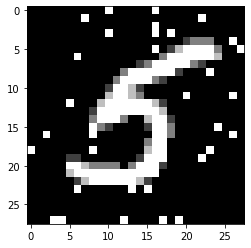

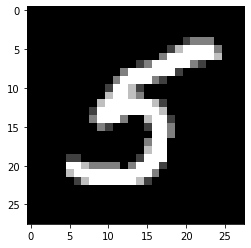

In [9]:
(train_images, _), (test_images, _) = mnist.load_data()

train_input_images, train_output_images = generate_data(train_images)
test_input_images, test_output_images = generate_data(test_images)

view_image(train_input_images[0].reshape(28, 28) * 255)
view_image(train_output_images[0].reshape(28, 28) * 255)

In [10]:
model = build_model()
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 28, 28, 8)         72        
_________________________________________________________________
batch_normalization_28 (Batc (None, 28, 28, 8)         32        
_________________________________________________________________
re_lu_28 (ReLU)              (None, 28, 28, 8)         0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 28, 28, 8)         576       
_________________________________________________________________
batch_normalization_29 (Batc (None, 28, 28, 8)         32        
_________________________________________________________________
re_lu_29 (ReLU)              (None, 28, 28, 8)         0   

In [11]:
model.compile(optimizer='rmsprop',
              loss='mse')

model.fit(x=np.array(train_input_images),
          y=np.array(train_output_images),
          validation_data=(np.array(test_input_images),
                            np.array(test_output_images)),
          batch_size=32,
          validation_batch_size=32,
          epochs=10)

Epoch 1/10
2344/2344 [==============================] - 24s 10ms/step - loss: 0.0224 - val_loss: 0.0101
Epoch 2/10
2344/2344 [==============================] - 22s 9ms/step - loss: 0.0062 - val_loss: 0.0060
Epoch 3/10
2344/2344 [==============================] - 22s 9ms/step - loss: 0.0049 - val_loss: 0.0043
Epoch 4/10
2344/2344 [==============================] - 22s 9ms/step - loss: 0.0043 - val_loss: 0.0045
Epoch 5/10
2344/2344 [==============================] - 22s 9ms/step - loss: 0.0039 - val_loss: 0.0040
Epoch 6/10
2344/2344 [==============================] - 22s 9ms/step - loss: 0.0036 - val_loss: 0.0033
Epoch 7/10
2344/2344 [==============================] - 22s 10ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 8/10
2344/2344 [==============================] - 22s 9ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 9/10
2344/2344 [==============================] - 22s 10ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 10/10
2344/2344 [==============================] - 23s 10ms/step

input image:


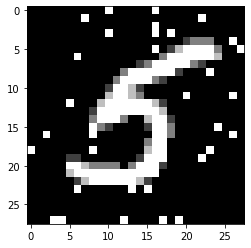

predicted output:


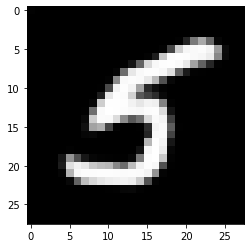

true output:


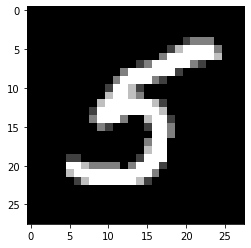

In [14]:
print('input image:')
view_image(train_input_images[0].reshape(28, 28) * 255)
print('predicted output:')
view_image(model.predict(np.array([train_input_images[0]]))[0].reshape(28, 28) * 255)
print('true output:')
view_image(train_output_images[0].reshape(28, 28) * 255)